In [2]:
!pip install git+https://github.com/energy-based-model/Compositional-Visual-Generation-with-Composable-Diffusion-Models-PyTorch
!pip install git+https://github.com/openai/glide-text2im

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/energy-based-model/Compositional-Visual-Generation-with-Composable-Diffusion-Models-PyTorch to /tmp/pip-req-build-t94pv5t1
  Running command git clone -q https://github.com/energy-based-model/Compositional-Visual-Generation-with-Composable-Diffusion-Models-PyTorch /tmp/pip-req-build-t94pv5t1
     |████████████████████████████████| 53 kB 1.7 MB/s 
  Created wheel for composable-diffusion: filename=composable_diffusion-0.0.0-py3-none-any.whl size=1957433 sha256=7e3b3f16a8cbe62b69fb6182497c22f54a0908f33a28ade34deba2f51e46526b
  Stored in directory: /tmp/pip-ephem-wheel-cache-yzk6sy4h/wheels/ed/0a/58/3df73374e86498e3d350e27cbf39c96f6b0d12dfcbf76505f4
Successfully built composable-diffusion
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-k5ex2b

In [3]:
from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)


In [4]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [5]:
# Create base model.
timestep_respacing =  100 #@param{type: 'number'}
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = str(timestep_respacing) # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

total base parameters 385030726


In [6]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398361286


In [7]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [11]:
# Sampling parameters
#@markdown `prompt`: when composing  multiple sentences, using `|` as the delimiter.
prompt = "a camel | a forest" #@param{type: 'string'}
prompts = [x.strip() for x in prompt.split('|')]
print(prompts)
batch_size = 1
guidance_scale = 10 #@param{type: 'number'}
# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.980 #@param{type: 'number'}

['a camel', 'a forest']


  0%|          | 0/100 [00:00<?, ?it/s]

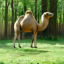

In [12]:
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
tokens_list = [model.tokenizer.encode(prompt) for prompt in prompts]
outputs = [model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
) for tokens in tokens_list]

cond_tokens, cond_masks = zip(*outputs)
cond_tokens, cond_masks = list(cond_tokens), list(cond_masks)

full_batch_size = batch_size * (len(prompts) + 1)
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        cond_tokens + [uncond_tokens], device=device
    ),
    mask=th.tensor(
        cond_masks + [uncond_mask],
        dtype=th.bool,
        device=device,
    ),
)

masks = [True] * len(prompts) + [False]
# coefficients = th.tensor([0.5, 0.5], device=device).reshape(-1, 1, 1, 1)
masks = th.tensor(masks, dtype=th.bool, device=device)

# Create a classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[:1]
    combined = th.cat([half] * x_t.size(0), dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps = eps[masks].mean(dim=0, keepdim=True)
    # cond_eps = (coefficients * eps[masks]).sum(dim=0)[None]
    uncond_eps = eps[~masks].mean(dim=0, keepdim=True)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps] * x_t.size(0), dim=0)
    return th.cat([eps, rest], dim=1)

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)

  0%|          | 0/27 [00:00<?, ?it/s]

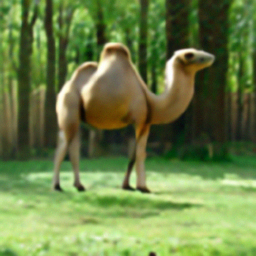

In [13]:
##############################
# Upsample the 64x64 samples #
##############################

tokens = model_up.tokenizer.encode("".join(prompts))
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

# Show the output
show_images(up_samples)